In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

## Importing and cleaning data

Loading the dataset:

In [2]:
path = '/kaggle/input/superconductivty-data-data-set/train.csv'
data = pd.read_csv(path)
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


Printing some basic information about the dataset:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

The dataset contains 21263 observations with 81 features and the target variable, critical_temp. Checking if the dataset contains any columns with missing values:

In [4]:
data.isnull().sum()[data.isnull().sum() != 0].sort_values()

Series([], dtype: int64)

Removing the missing values, since there are only a few rows containing them compared to the total number of observations:

In [5]:
data.dropna(inplace=True)

As we see there are no columns with any missing values. Checking if there are any duplicate rows:

In [6]:
data.duplicated().sum()

66

We see that there are 66 duplicate rows. We proceed to remove them, since the number of duplicate rows is very small compared to the number of observations in the dataset:

In [7]:
data = data.drop_duplicates()

Checking the data types of the variables in the dataset:

In [8]:
data.dtypes.value_counts()

float64    79
int64       3
dtype: int64

There are 79 variables containing float values, and 3 containing integers.

## EDA and feature engineering

Printing some basic statistical data about the columns of the dataset:

In [9]:
data.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,...,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000,21197.000000
mean,4.120300,87.544201,72.945331,71.253164,58.474874,1.166782,1.065103,115.751945,33.204053,44.436401,...,3.148856,3.052542,3.051485,1.297020,1.053977,2.042553,1.480890,0.839692,0.674168,34.494532
std,1.438282,29.643136,33.460789,30.990774,36.615381,0.364712,0.401225,54.584784,26.966285,20.019732,...,1.189878,1.044637,1.173221,0.392834,0.380121,1.243242,0.977545,0.485002,0.456038,34.276465
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.522475,52.143839,58.041225,35.247208,0.972995,0.781227,78.899680,16.799962,32.890369,...,2.116279,2.267933,2.090896,1.060857,0.778998,1.000000,0.921250,0.451754,0.306892,5.380000
50%,4.000000,84.922750,60.689236,66.361592,39.873869,1.199541,1.148465,122.906070,26.601500,45.123500,...,2.605455,2.615321,2.428047,1.368922,1.169665,2.000000,1.062857,0.800000,0.500000,20.000000
75%,5.000000,100.374260,85.982703,78.019689,73.056021,1.444537,1.360388,154.119320,38.336200,59.356406,...,4.007317,3.662842,3.909523,1.589027,1.331531,3.000000,1.910400,1.200000,1.021023,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


The different columns have quite different means and standard deviations, which means that they are measured on different scales. This should be kept in mind when fitting models that rely on notions of distance -- such as regularized linear models.

Plotting the correlation heatmap:

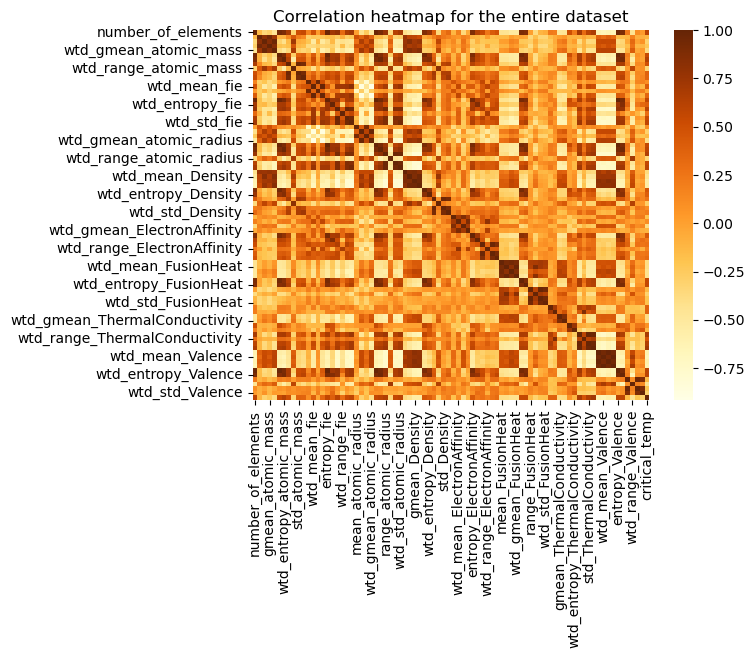

In [10]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap='YlOrBr')
plt.title('Correlation heatmap for the entire dataset')
plt.show()

Some of the blocks off the diagonal are highly correlated, showing that some multicollinearity is present. This is an issue for linear models, but not for tree based models, so it can be expected that tree based models will have superior performance. Seperating the data into features and targets:

In [11]:
X = data.drop('critical_temp', axis=1).values
y = data['critical_temp'].values

Scaling the features to make sure that they all have the same mean and standard deviation:

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

The data is now ready for building models.

## Model building and evaluation

Initial exploration with some of the models considered below showed that model performance on the last few folds of the data (without shuffling) was consistently and significantly better than on the first few folds. Because of this, we shuffle the data before splitting it into folds. Setting up a CV objects:

In [13]:
cv_3 = KFold(3, shuffle=True, random_state=42)
cv_5 = KFold(5, shuffle=True, random_state=42)
cv_10 = KFold(10, shuffle=True, random_state=42)

Defining function to get cross validated root mean squared error:

In [14]:
def get_model_and_scores(model, model_name):
    score = np.sqrt(np.mean(np.abs(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv_10, n_jobs=-1, verbose=1))))
    return [model_name, score]

Creating a dataframe with no entries to store model results:

In [15]:
models = pd.DataFrame(columns=['Model', 'Cross-validated root mean squared error'])

Defining a function to append model and score to models dataframe:

In [16]:
def append_model_and_scores(model_and_scores):
    models.loc[len(models)] = model_and_scores
    return models.drop_duplicates()

Defining function to get grid/random search results in a dataframe:

In [17]:
def get_cv_results(grid_search_object, n=5):
    cv_results = pd.DataFrame(grid_search_object.cv_results_).sort_values('rank_test_score').head(n)
    return cv_results

#### Baseline model: l2-regularized spline regression

*As our baseline model, we use an l2-regularized spline regression. A spline regression can be thought of as a way of adding non-linearity to the linear regression model. It involves fitting separate low-degree polynomials over different regions of the explanatory variables. The points marking the boundaries of the different regions where separate polynomials are fitted are called knots. The spline regression fits the polynomials in such a way as to make the overall estimated regression function continuous and smooth at the knots. L2 regularization was added to the spline regression model to shrink the coefficients of the variables with low explanatory power towards zero (but not to exactly zero, as in l1 regularization), thus reducing the chances of overfitting.*

*All model hyperparameters were chosen using grid searches. A grid search requires us to specify a range of hyperparameter values to choose from. Then, models are estimated using each combination of hyperparameter values and are evaluated using cross-validation. The optimal hyperparameters are the ones that give the best model as measured by the ROC-AUC score, in our case.*

*Cross-validation is a technique that allows us to estimate the performance of the model on unseen data. The dataset is split into $n$ folds. In each iteration, the model is estimated using data from $n-1$ folds and is evaluated on the remaining fold. This procedure is repeated $n$ times, so each fold is used once as a validation set, and an average evaluation metric is computed. Three-fold stratified cross-validation was used for all the models in this section. Stratified cross-validation means that the proportion of the categories of the target variable are the same in each fold.*

Using a grid search to find the optimal number of knots and the regularization hyperparameter:

In [18]:
spline = SplineTransformer(degree=3)
ridge = Ridge(random_state=42)
spline_pipeline = Pipeline(steps=[('spline', spline), ('ridge', ridge)])

params= {'spline__n_knots': [15, 20],
            'ridge__alpha': np.linspace(-1, 10, 10)}

spline_cv = GridSearchCV(spline_pipeline, param_grid=params, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv_5)
spline_cv.fit(X, y)
get_cv_results(spline_cv, 10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,param_spline__n_knots,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,4.948384,0.042739,0.300373,0.042027,1.444444,20,"{'ridge__alpha': 1.4444444444444446, 'spline__...",-180.742530,-182.456735,-191.004677,-189.650302,-183.600072,-185.490863,4.075065,1
3,5.132362,0.173306,0.298694,0.014037,0.222222,20,"{'ridge__alpha': 0.22222222222222232, 'spline_...",-183.097211,-183.492979,-189.713127,-189.876019,-182.664866,-185.768840,3.297821,2
7,4.901975,0.071200,0.295274,0.015263,2.666667,20,"{'ridge__alpha': 2.666666666666667, 'spline__n...",-181.012215,-182.919129,-192.016765,-189.924667,-184.561992,-186.086954,4.195338,3
9,4.875473,0.134617,0.297080,0.003911,3.888889,20,"{'ridge__alpha': 3.8888888888888893, 'spline__...",-181.453511,-183.371328,-192.815158,-190.257995,-185.350732,-186.649745,4.253659,4
11,4.870861,0.117670,0.301575,0.011351,5.111111,20,"{'ridge__alpha': 5.111111111111112, 'spline__n...",-181.914370,-183.795714,-193.496533,-190.600538,-186.035860,-187.168603,4.291557,5
13,4.783016,0.030863,0.300922,0.016120,6.333333,20,"{'ridge__alpha': 6.333333333333334, 'spline__n...",-182.364770,-184.197955,-194.104169,-190.942704,-186.652976,-187.652515,4.320706,6
15,4.809989,0.022565,0.293926,0.008668,7.555556,20,"{'ridge__alpha': 7.555555555555557, 'spline__n...",-182.797829,-184.582879,-194.660697,-191.281964,-187.221560,-188.108986,4.345620,7
17,4.999266,0.152033,0.293928,0.011510,8.777778,20,"{'ridge__alpha': 8.777777777777779, 'spline__n...",-183.212779,-184.953764,-195.179334,-191.617555,-187.753306,-188.543348,4.368325,8
19,4.430883,0.539816,0.226205,0.058557,10.0,20,"{'ridge__alpha': 10.0, 'spline__n_knots': 20}",-183.610644,-185.312861,-195.668455,-191.949251,-188.255789,-188.959400,4.389809,9
2,3.672419,0.270917,0.278591,0.033629,0.222222,15,"{'ridge__alpha': 0.22222222222222232, 'spline_...",-189.413194,-190.601298,-196.933316,-196.984319,-193.385335,-193.463492,3.131743,10


Extracting the best model:

In [19]:
spline_final = spline_cv.best_estimator_

spline_model_and_score = get_model_and_scores(spline_final, 'Spline regression')
append_model_and_scores(spline_model_and_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.8s finished


,Model,Cross-validated root mean squared error
0,Spline regression,13.587833


We see that the spline regression has a root mean squared error of around 13.59 Kelvins.

#### Random forest

*As our next model, we considered a random forest, which is a tree-based ensemble method.*

*A decision tree is a classification/regression method that works by recursively splitting the feature space into two parts until some stopping criterion, such as the depth of the tree, is met. This produces a tree-like representation of the feature space. Predictions are made by following the decision tree from the top of the tree to the bottom subset, where the prediction is made as the mean value of the observations in the bottom subset in case of regression, and as the most frequent class in case of classification.*

*The random forest model works by generating $n$ bootstrap samples from the original dataset with a random subset of features taken in each bootstrap sample. Bootstrap samples are formed by randomly selecting $m$ observations from the original dataset with replacement, where $m$ is the number of observations in the original training set. Finally, the most frequent outcome predicted by the individual decision trees is taken as the final prediction made by the random forest model.*

*The number of trees in the random forest was fixed at 750, and the maximum fraction of features used to train each tree and the maximum depth of each tree were determined using a grid search with 5-fold cross-validation. In the chosen random forest model, each tree has a maximum depth of 20 nodes and is trained on 50% of the features, chosen at random.*

*The random forest model performs better than the spline regression, with a cross-validated RMSE of around 9.06 Kelvins – beating the score achieved by the author’s model in the original paper.*

Fixing the number of base estimators at 750, and performing a grid search to find the optimal values for the maximum number of features considered by each estimator and the depth of each tree:

In [20]:
rf = RandomForestRegressor(n_estimators=750, random_state=42)

params = {'max_features': [0.20, 0.30, 0.50],
            'max_depth': [10, 20, 50]}
rf_cv = GridSearchCV(rf, param_grid=params, cv=cv_5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_cv.fit(X, y)
get_cv_results(rf_cv)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,474.335458,1.502328,0.999452,0.030930,20,0.5,"{'max_depth': 20, 'max_features': 0.5}",-85.521132,-78.815468,-88.721747,-86.233234,-84.124373,-84.683191,3.291114,1
4,293.187004,0.509680,0.971133,0.010464,20,0.3,"{'max_depth': 20, 'max_features': 0.3}",-86.005751,-78.645998,-88.984001,-85.701437,-84.390676,-84.745572,3.399905,2
7,306.926915,0.694825,1.072547,0.027748,50,0.3,"{'max_depth': 50, 'max_features': 0.3}",-85.917251,-79.268284,-89.251919,-85.563620,-84.168271,-84.833869,3.244817,3
3,200.655201,0.272188,1.105276,0.138539,20,0.2,"{'max_depth': 20, 'max_features': 0.2}",-86.360911,-79.405286,-88.771836,-85.468944,-84.430458,-84.887487,3.093886,4
6,211.594119,0.730311,1.112501,0.084031,50,0.2,"{'max_depth': 50, 'max_features': 0.2}",-86.494966,-79.407867,-89.050130,-85.176173,-84.316912,-84.889209,3.173222,5


Extracting the best model:

In [21]:
rf_final = rf_cv.best_estimator_

rf_model_and_scores = get_model_and_scores(rf_final, 'Random forest')
append_model_and_scores(rf_model_and_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 23.9min finished


,Model,Cross-validated root mean squared error
0,Spline regression,13.587833
1,Random forest,9.055525


We see that the random forest model performs better than the spline regression, with a root mean squared error of around 9.06 Kelvins -- beating the score achieved by the author's model in the original paper. Let's see if we can further improve on this score.

#### Gradient boosted regression trees using XGBoost

*Gradient boosting is another tree-based ensemble method. Unlike the random forest model, which trains separate trees on several bootstrap samples in parallel, gradient boosting trains trees in sequence, where each tree seeks to find patterns in the part of the variation in the data that is not explained by the previous trees. The predictions produced by the gradient boosted regression tree model can be thought of as being a weighted linear combination of the predictions of a regression tree trained on the original dataset, a regression tree fit using the residuals from the first tree as features, a regression tree fit using the residuals from the second tree as features, and so on.*

*To implement the gradient boosted regression tree model, we used the XGBoost algorithm. This is an efficient gradient boosting algorithm with support for regularization to reduce overfitting. The optimal hyperparameters for this model were chosen using a randomized search, which is similar to the grid search previously described, with the only difference being that a random subset of combinations of hyperparameter values is considered instead of the entire set of all combinations of the provided hyperparameter values. Although the randomized search approach does not guarantee that the optimal combination of hyperparameter values among all possible combinations will be found, its use here was necessitated by the fact that the XGBoost algorithm has a lot of hyperparameters to be tuned which produces a large number of combinations of hyperparameter values, making a thorough grid search infeasible due to time constraints.*

*The chosen XGBoost model has 750 base estimators, each of which is trained on separate random subsamples containing 75% of the observations and 30% of the features. Each tree is grown to a maximum depth of 20, and the chosen regularization hyperparameters indicate that regularization is relatively strong in the model. The XGBoost model slightly outperforms the random forest model, with a cross-validated RMSE of around 8.89.*

Conducting the random search:

In [22]:
xgb = XGBRegressor(random_state=42)
params = {'n_estimators': [750],
            'max_depth': [10, 20],
            'min_child_weight': [5, 10],
            'learning_rate': [0.01, 0.02],
            'subsample': [0.75],
            'colsample_bytree': [0.2, 0.3],
            'alpha': [0, 1, 2],
            'lambda': [0, 1, 10],
            'gamma': [2, 5, 10]
            }
xgb_cv = RandomizedSearchCV(xgb, param_distributions=params, scoring='neg_mean_squared_error', n_iter=20, cv=cv_3, random_state=42, verbose=1, n_jobs=-1)
xgb_cv.fit(X, y)

get_cv_results(xgb_cv, 10)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_lambda,param_gamma,param_colsample_bytree,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,194.101555,0.179622,1.338775,0.035710,0.75,750,10,20,0.01,0,2,0.3,0,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-85.484450,-87.675854,-86.532289,-86.564197,0.894921,1
5,189.617067,0.576075,1.204493,0.016754,0.75,750,10,20,0.01,1,10,0.3,1,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-85.550497,-88.035937,-86.410403,-86.665612,1.030599,2
8,141.178249,0.685064,1.324107,0.112825,0.75,750,10,20,0.01,0,10,0.2,1,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-85.776521,-88.101900,-86.922702,-86.933708,0.949364,3
7,149.064186,0.304067,1.469500,0.003949,0.75,750,5,20,0.01,1,2,0.2,1,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-85.805028,-87.995290,-87.287611,-87.029310,0.912634,4
14,141.295051,0.460265,1.239465,0.022684,0.75,750,10,20,0.02,1,5,0.2,0,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-86.114741,-88.563542,-86.829551,-87.169278,1.028175,5
2,79.745013,0.399377,0.544072,0.016876,0.75,750,5,10,0.02,1,5,0.2,1,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-86.020617,-88.724417,-87.589481,-87.444839,1.108550,6
11,146.175147,0.278426,1.326921,0.021877,0.75,750,5,20,0.02,10,10,0.2,0,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-86.542791,-88.598933,-87.597463,-87.579729,0.839510,7
13,146.004701,0.221790,1.317670,0.008528,0.75,750,5,20,0.02,10,5,0.2,2,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-86.337962,-88.920004,-87.640956,-87.632974,1.054129,8
12,143.376412,0.751798,1.228180,0.017522,0.75,750,10,20,0.02,0,10,0.2,1,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-86.027229,-89.349632,-87.576638,-87.651166,1.357389,9
16,201.794227,0.647669,1.352432,0.011368,0.75,750,5,20,0.02,10,2,0.3,2,"{'subsample': 0.75, 'n_estimators': 750, 'min_...",-86.763139,-89.087754,-87.412798,-87.754563,0.979306,10


Extracting the best model:

In [23]:
xgb_final = xgb_cv.best_estimator_

xgb_model_and_scores = get_model_and_scores(xgb_final, 'XGBoost')
append_model_and_scores(xgb_model_and_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 11.5min finished


,Model,Cross-validated root mean squared error
0,Spline regression,13.587833
1,Random forest,9.055525
2,XGBoost,8.888523


We see that the XGBoost model slighly outperforms the random forest, with an RMSE of 8.89 Kelvins. We have therefore achieved our objective of beating the RMSE obtained by the authors in their paper using our XGBoost model.